In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import sys
sys.path.append('../ca2-mec')
import data_processing as dp
from trackunitmulticomparison import TrackMultipleSessions
from registration import store_notebook
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import quantities as pq
import exdir
from distutils.dir_util import copy_tree
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import networkx as nx
#from nxpd import draw
%matplotlib inline

In [3]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [4]:
output = pathlib.Path('output/identify_neurons')
output.mkdir(parents=True, exist_ok=True)

In [5]:
identify_neurons = project.require_action('identify-neurons')

In [6]:
actions['011-120321-2'].attributes

{'registered': '2021-03-12T19:13:24',
 'datetime': '2021-03-12T16:51:52',
 'type': 'Recording',
 'tags': ['open-ephys'],
 'entities': ['011'],
 'users': ['sarah'],
 'location': 'ibv',
 'data': {'main': 'actions\\011-120321-2\\data\\main.exdir'}}

In [7]:
data_loader = dp.Data()

In [8]:
skip_actions = [

]

In [9]:
sessions = []
for action in actions.values():
    if action.id in skip_actions:
        continue
    if action.type != 'Recording':
        continue
    action_data_path = dp.get_data_path(action)
    exdir_object =  exdir.File(action_data_path)
    if 'processing' not in exdir_object:
        continue
        
    processing = exdir_object['processing']
    
    if not 'electrophysiology' in processing:
        continue
    elphys = processing['electrophysiology']
    if 'spikesorting' not in elphys:
        continue  

    sessions.append({
       'action': action.id,
       'session': int(action.id.split('-')[-1]),
       'entity': int(action.entities[0]),

   })
sessions = pd.DataFrame(sessions)

In [10]:
sessions

,action,session,entity
0,001-101220-1,1,1
1,001-181220-2,2,1
2,001-181220-3,3,1
3,001-181220-4,4,1
4,001-181220-5,5,1
...,...,...,...
106,133-270520-1,1,133
107,134-260520-2,2,134
108,134-270520-2,2,134
109,137-230121-2,2,137


In [11]:
sessions['date'] = sessions.apply(lambda x: x.action.split('-')[1], axis=1)
sessions['entity_date'] = sessions.apply(lambda x: '-'.join(x.action.split('-')[:2]), axis=1)

In [12]:
sessions.to_csv(output / 'sessions.csv', index=False)

# Identify unique neurons

In [13]:
include = ["011-120321-2",
          "011-120321-3",
          "011-120321-4",
          "011-120321-5",
          "011-120321-6"]

In [14]:
sessions_include = sessions.query("action.isin(@include)")

In [15]:
sessions_include

,action,session,entity,date,entity_date
62,011-120321-2,2,11,120321,011-120321
63,011-120321-3,3,11,120321,011-120321
64,011-120321-4,4,11,120321,011-120321
65,011-120321-5,5,11,120321,011-120321
66,011-120321-6,6,11,120321,011-120321


In [16]:
# save graphs
for entity, values in sessions_include.groupby('entity'):
    data_path = output / f'{entity}-graphs'
    if data_path.exists():
        shutil.rmtree(data_path)
#         continue
    print('Processing', entity)
    unit_matching = TrackMultipleSessions(
        actions, action_list=values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.do_matching()
    unit_matching.make_graphs_from_matches()
#     unit_matching.compute_time_delta_edges()
    unit_matching.compute_depth_delta_edges()
    # save graph with all dissimilarities for later use
    unit_matching.save_graphs()

Processing 11


  0%|          | 0/10 [00:00<?, ?it/s]

# Plot comparisons

In [17]:
entity = "11"
unit_comp = TrackMultipleSessions(
    actions, sessions_include.action.values, data_path=f'output/identify_neurons/{entity}-graphs')

In [18]:
unit_comp.load_graphs()

In [19]:
max_dissimilarity = .05
max_depth_delta = 100

unit_comp.remove_edges_above_threshold('weight', max_dissimilarity)
unit_comp.remove_edges_above_threshold('depth_delta', max_depth_delta)

In [20]:
unit_comp.remove_edges_with_duplicate_actions()
unit_comp.identify_units()

Zero units found on channel group 0
Zero units found on channel group 2
Zero units found on channel group 4
Zero units found on channel group 5
Zero units found on channel group 6
Zero units found on channel group 7


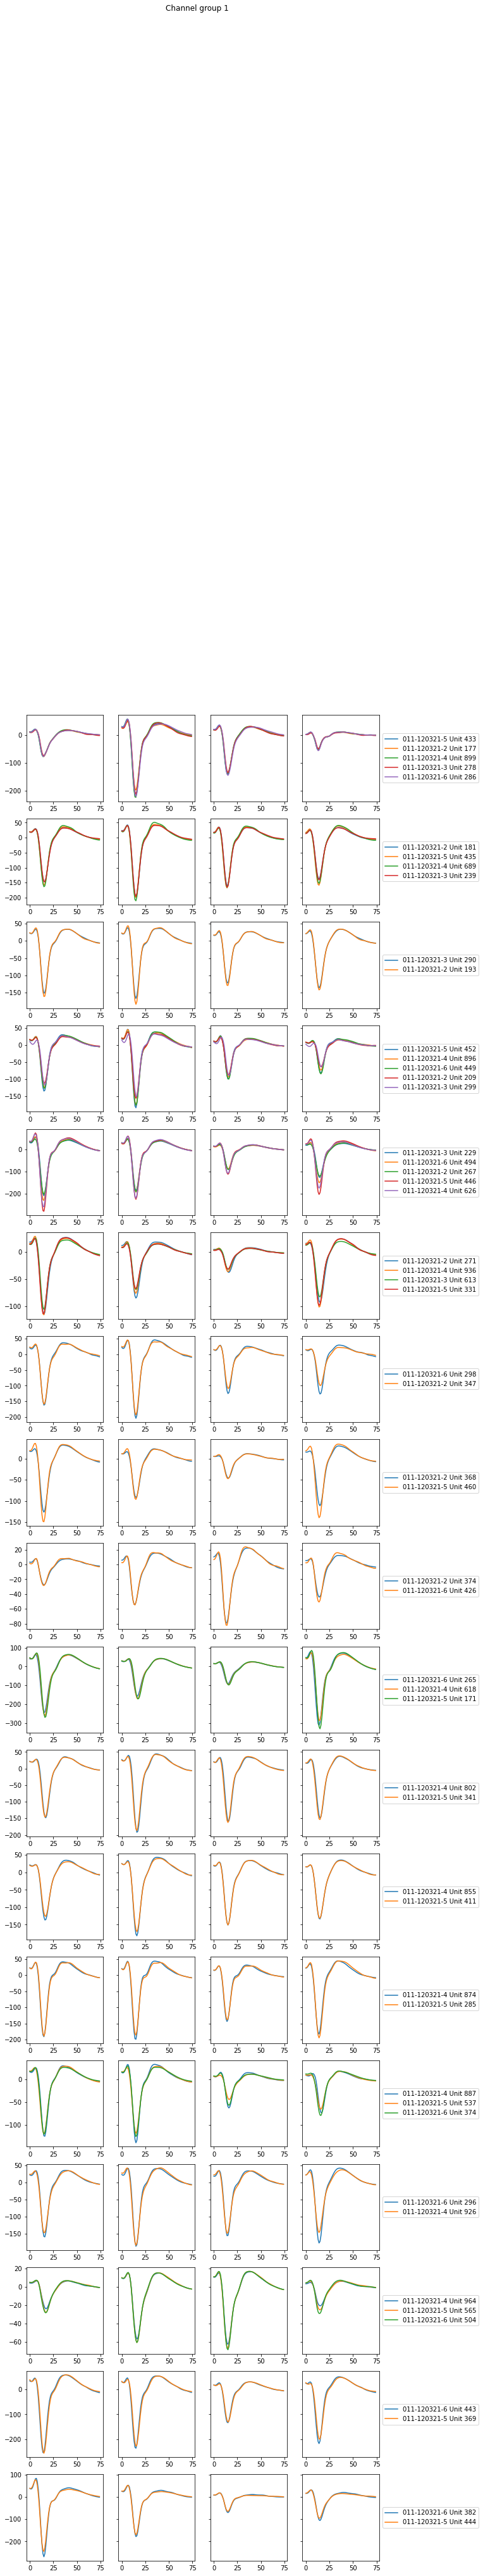

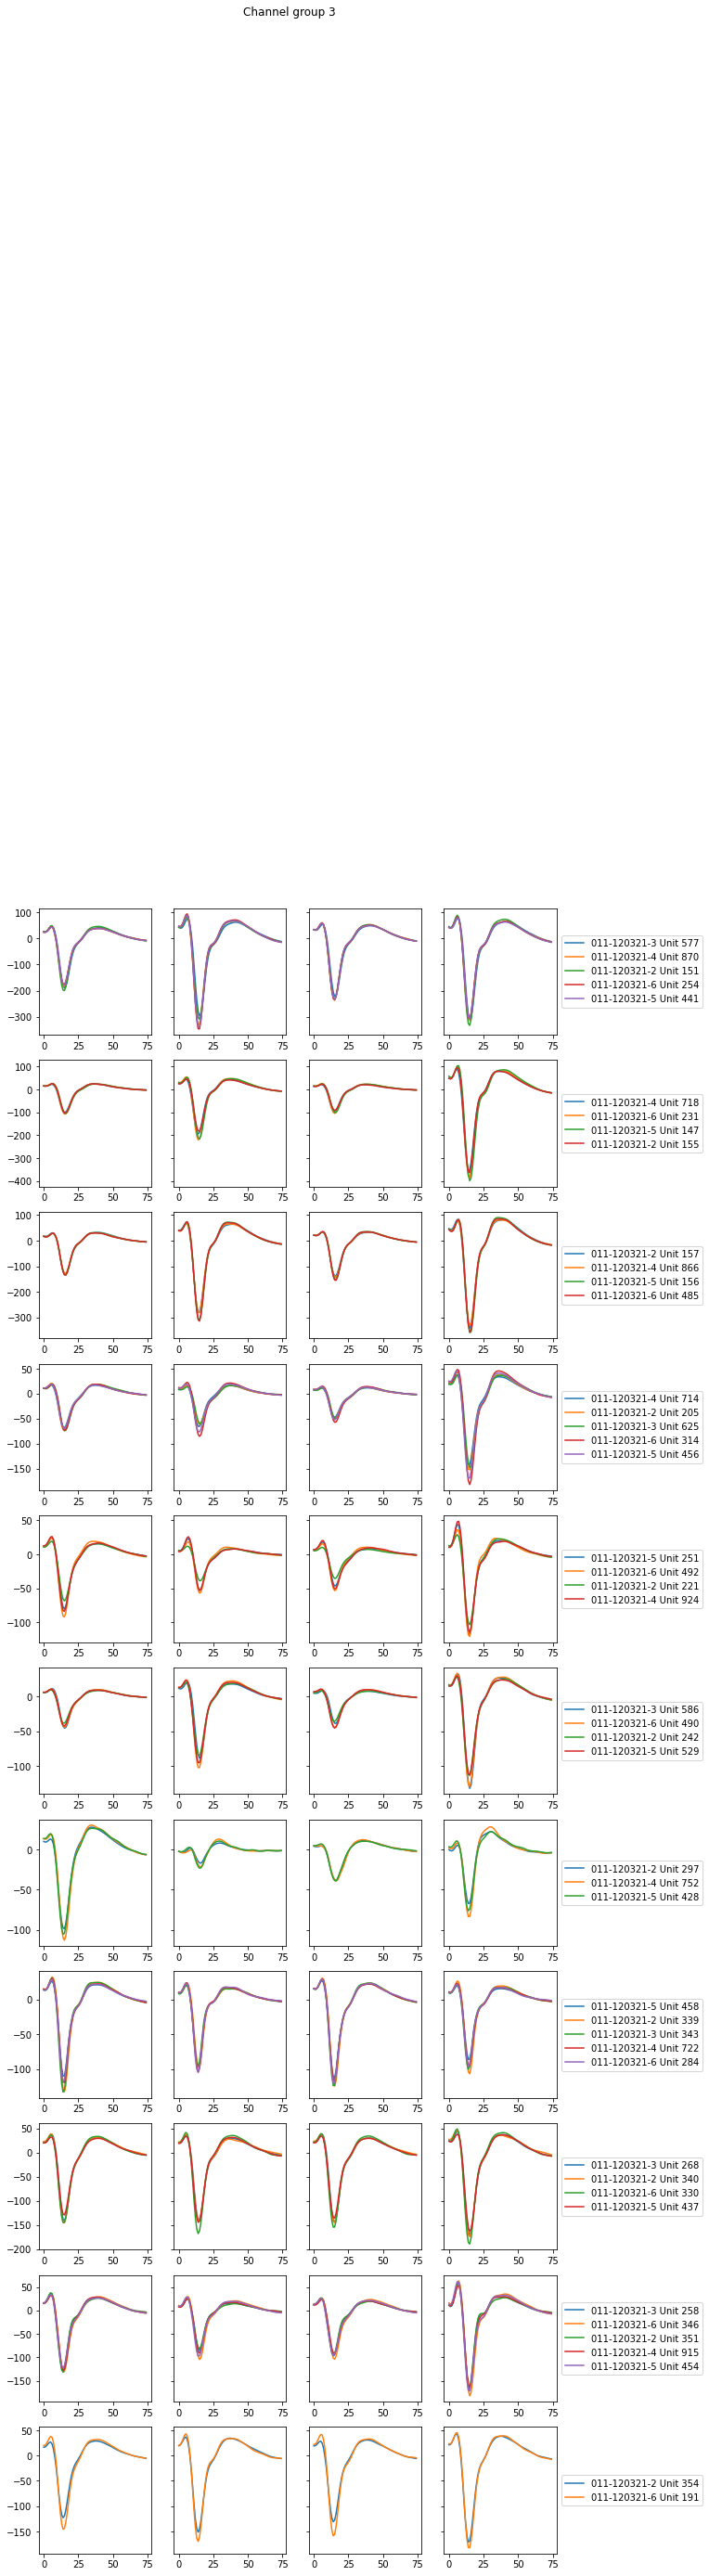

In [21]:
#unit_comp.plot_matches('template', chan_group=1, step_color=False)
unit_comp.plot_matches('template', step_color=False)

#plt.tight_layout()

# Store uniqe unit ids to csv

In [22]:
max_dissimilarity = .05
max_depth_delta = 100
id_nums = {}
num = 0
for entity, values in sessions_include.groupby('entity'):
    data_path = output / f'{entity}-graphs'
    unit_matching = TrackMultipleSessions(
        actions, values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.load_graphs()
    # cutoff large dissimilarities
    unit_matching.remove_edges_above_threshold('weight', max_dissimilarity)
    unit_matching.remove_edges_above_threshold('depth_delta', max_depth_delta)
    unit_matching.remove_edges_with_duplicate_actions()
    unit_matching.identify_units()
    units = []
    for ch, group in unit_matching.identified_units.items():
        for unit_id, val in group.items():
            for action_id, orig_unit_ids in val['original_unit_ids'].items():
                if unit_id not in id_nums:
                    id_nums[unit_id] = num
                    num += 1
                units.extend([
                    {
                        'unit_name': name, 
                        'unit_idnum': id_nums[unit_id],
                        'unit_id': unit_id, 
                        'action': action_id,
                        'channel_group': ch,
                        'max_dissimilarity': max_dissimilarity,
                        'max_depth_delta': max_depth_delta
                    } 
                    for name in orig_unit_ids])
    units = pd.DataFrame(units)
    units = units[~units.action.isin(skip_actions)]
    units.to_csv(output / f'{entity}-units.csv', index=False)

In [23]:
unique_units = pd.concat([
    pd.read_csv(p) 
    for p in output.iterdir() 
    if p.name.endswith('-units.csv')])

In [24]:
unique_units.to_csv(output / 'units.csv', index=False)

# Store results in Expipe action

In [25]:
identify_neurons.data['sessions'] = 'sessions.csv'
identify_neurons.data['units'] = 'units.csv'

In [26]:
copy_tree(output, str(identify_neurons.data_path()))

['D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\1-graphs\\graph-group-0.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\1-graphs\\graph-group-1.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\1-graphs\\graph-group-2.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\1-graphs\\graph-group-3.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\1-graphs\\graph-group-4.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\1-graphs\\graph-group-5.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\1-graphs\\graph-group-6.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\1-graphs\\graph-group-7.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\11-graphs\\graph-group-0.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\11-graphs\\graph-group-1.yaml',
 'D:\\projects\\ca2mec\\actions\\identify-neurons\\data\\11-graphs\\graph-group-2.yaml',
 'D:\\projects\\ca2mec\\actio

In [27]:
store_notebook(
    identify_neurons, "00-identify-neurons.ipynb")